In [1]:
import pathlib, sys

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [2]:
import math
from dataclasses import replace

from tqdm import tqdm
import numpy as np
import sympy as sp
import qutip
import matplotlib.pyplot as plt
from IPython.display import display, Math


def print_math(expr):
    display(Math(expr))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec

In [4]:
n_bosons = 3
phase = 0  # np.pi / 4
# model = BEC_Qubits.init_alexey2003(n_bosons=n_bosons, phase=phase)
model = bec.BEC_Qubits.init_default(n_bosons=n_bosons, phase=phase)
print(model)
print_math(f"G = {model.G:.3e}" + "\mbox{ (Coupling strength)}")
print_math(r"\Delta = " + f"{model.delta:.3e}")
print_math(r"\frac{G^2}{\Delta} = " + f"{model.G**2 / model.delta:.0e}")
print_math(r"\frac \Delta G = " + f"{model.delta / model.G :.0e}" + " \gg 1")
print_math(r"\Omega = " + f"{model.Omega}")

BEC_Qubits(n_bosons=3, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
tspan, dt = np.linspace(0, 2 / model.Omega, 5001, retstep=True)

## Эволюция под действием гамильтониана $H^\mathrm{tot}_\mathrm{eff}$

In [6]:
h_eff_tot = bec.h_eff_total(
    model
)  # здесь оmega это константа зеемановской части, а d перед zz

omega = -2.725e-01; d = 5.000e-04


In [7]:
init_state = (
    bec.coherent_state_constructor(model, n=2, k=0)
    * bec.coherent_state_constructor(model, 2, 1, math.sqrt(1 / 10), math.sqrt(9 / 10))
    * bec.vacuum_state(model, n=2)
)

In [8]:
result = qutip.mesolve(h_eff_tot, init_state, tspan, [], [], progress_bar=True)
states_under_h_eff_tot = list(result.states)

10.0%. Run time:   0.12s. Est. time left: 00:00:00:01
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.33s. Est. time left: 00:00:00:00
40.0%. Run time:   0.43s. Est. time left: 00:00:00:00
50.0%. Run time:   0.54s. Est. time left: 00:00:00:00
60.0%. Run time:   0.64s. Est. time left: 00:00:00:00
70.0%. Run time:   0.74s. Est. time left: 00:00:00:00
80.0%. Run time:   0.84s. Est. time left: 00:00:00:00
90.0%. Run time:   0.94s. Est. time left: 00:00:00:00
Total run time:   1.04s


### Фиделити состояния всей системы

In [9]:
fidelity_span = [
    qutip.metrics.fidelity(init_state, s)
    for s in tqdm(states_under_h_eff_tot, ncols=80)
]

100%|████████████████████████████████████| 5001/5001 [00:00<00:00, 96577.72it/s]


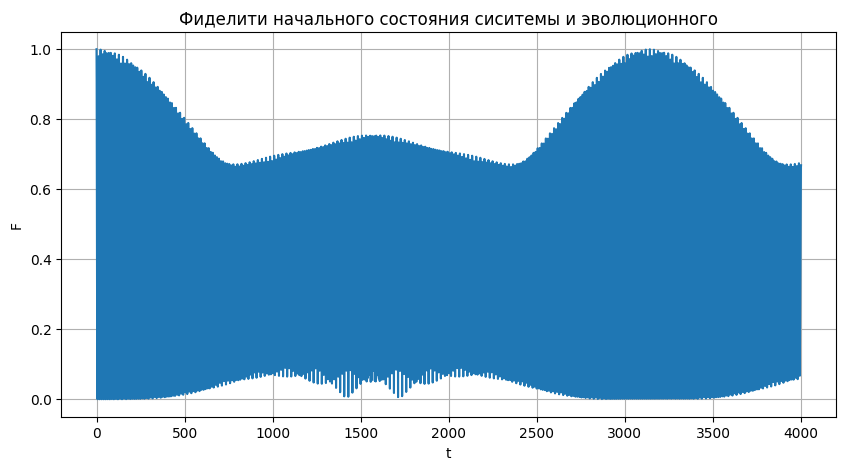

In [10]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fidelity_span)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделити начального состояния сиситемы и эволюционного")
ax.grid()

### Фиделити между кубитами

Фиделити в начальный момент времени

In [11]:
qutip.metrics.fidelity(
    qutip.ptrace(init_state * init_state.dag(), [0, 1]),
    qutip.ptrace(init_state * init_state.dag(), [2, 3]),
)

0.7155417527999326

Фиделети между эволюционными состояниями кубитов

In [12]:
fidelity_span12 = [
    np.round(
        qutip.metrics.fidelity(
            qutip.ptrace(s * s.dag(), [0, 1]), qutip.ptrace(s * s.dag(), [2, 3])
        ),
        7,
    )
    for s in tqdm(states_under_h_eff_tot, ncols=80)
]

100%|██████████████████████████████████████| 5001/5001 [00:05<00:00, 918.86it/s]


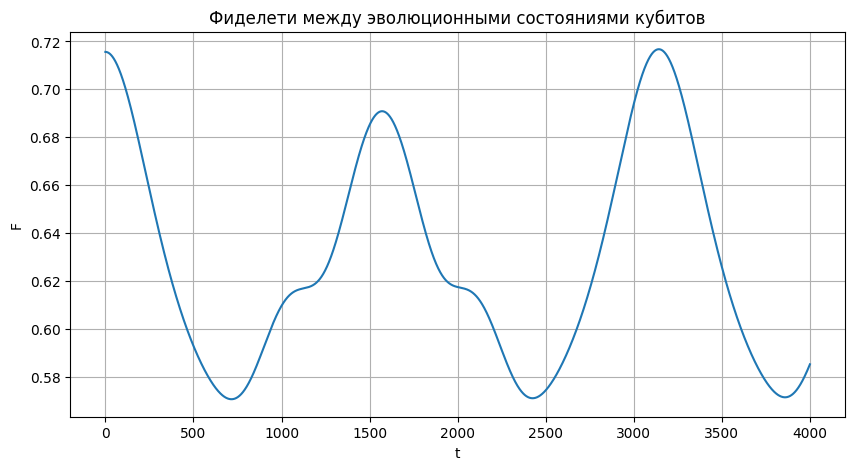

In [13]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fidelity_span12)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделети между эволюционными состояниями кубитов")
ax.grid()

### Фиделити состояний первого и второго кубита по отношению к начальному состоянию

In [14]:
init_rho1 = qutip.ptrace(init_state, [2, 3])
init_rho2 = qutip.ptrace(init_state, [0, 1])
fidelity_span1 = [
    np.round(qutip.metrics.fidelity(init_rho1, qutip.ptrace(s * s.dag(), [2, 3])), 7)
    for s in tqdm(states_under_h_eff_tot, ncols=80)
]
fidelity_span2 = [
    np.round(qutip.metrics.fidelity(init_rho2, qutip.ptrace(s * s.dag(), [0, 1])), 7)
    for s in tqdm(states_under_h_eff_tot, ncols=80)
]

100%|██████████████████████████████████████| 5001/5001 [00:05<00:00, 909.01it/s]


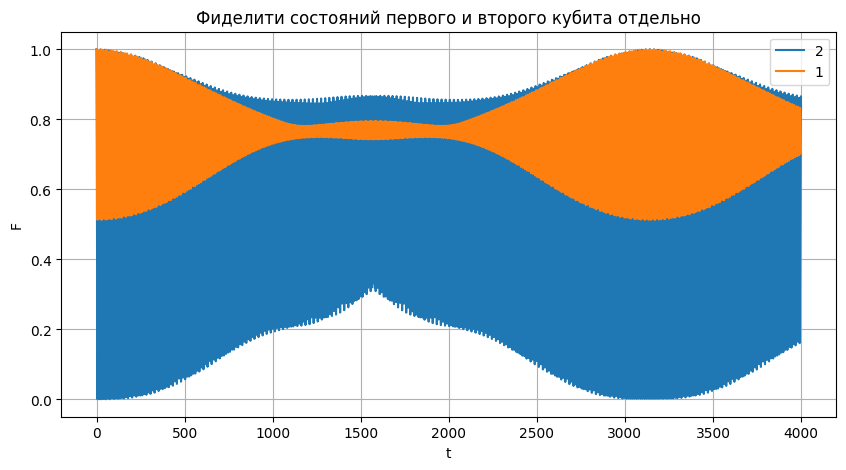

In [15]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fidelity_span2, "-", label="2")
ax.plot(tspan, fidelity_span1, "-", label="1")
ax.set_xlabel("t")
ax.set_ylabel("F")
ax.set_title("Фиделити состояний первого и второго кубита отдельно")
ax.legend()
ax.grid()

### Среднее значене $S_z$

In [16]:
e_opts = [bec.sz(model, 2, 0) + bec.sz(model, 2, 1)]
r = qutip.mesolve(h_eff_tot, init_state, tspan, [], e_opts)

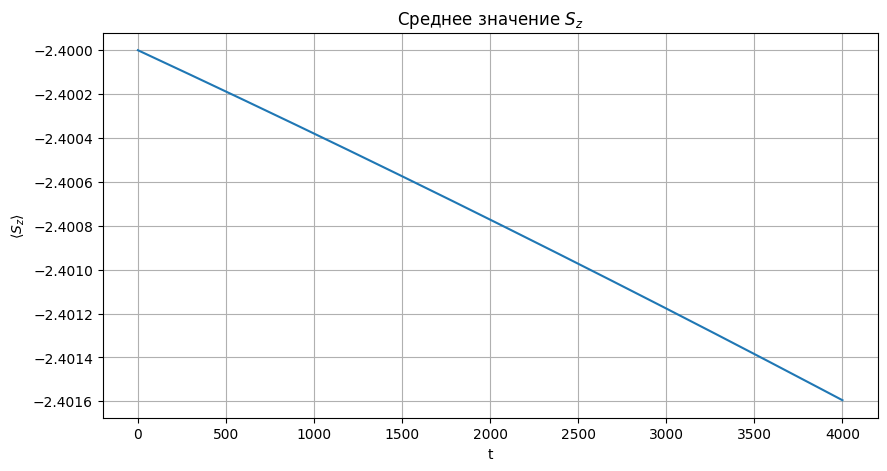

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, r.expect[0], "-")
ax.set_ylabel(r"$\langle S_z \rangle$")
ax.set_xlabel("t")
ax.set_title("Среднее значение $S_z$")
ax.grid()

## Эволючия под действием zz части гамильтониана $H^\mathrm{tot}_\mathrm{eff}$ где $\phi = 0$

In [18]:
hzz = bec.hzz(model)

In [19]:
init_state = (
    bec.coherent_state_constructor(model, 2, 0)
    * bec.coherent_state_constructor(model, 2, 1)
    * bec.vacuum_state(model)
)

In [20]:
def states_under_hzz_teor(t):
    """
    Эволюционные состояния (теория) системы двух кубитов, с начальным суперпозиционным состоянием.
    """

    def alpha(k, t):
        return np.exp(1j * (model.n_bosons - 2 * k) * model.Omega * t) / math.sqrt(2)

    def beta(k, t):
        return alpha(k, t).conjugate()

    return sum(
        (
            math.sqrt(math.comb(model.n_bosons, k))
            * bec.coherent_state_constructor(model, 2, 0, alpha(k, t), beta(k, t))
            * bec.fock_state_constructor(model, 2, 1, k)
            * bec.vacuum_state(model)
        )
        for k in range(model.n_bosons + 1)
    ) / math.sqrt(2**model.n_bosons)

In [21]:
states_under_hzz_teor_span = [states_under_hzz_teor(t) for t in tqdm(tspan, ncols=80)]

100%|██████████████████████████████████████| 5001/5001 [00:19<00:00, 255.78it/s]


In [22]:
options = qutip.Options(nsteps=1e6)  # бестолковая настройка
states_under_hzz_span = qutip.mesolve(hzz, init_state, tspan, options=options).states

Фиделити состояния системы во времени между теорией и mesolve

In [23]:
fid_teor_vs_mesolve = [
    np.round(qutip.metrics.fidelity(s1, s2), 7)
    for s1, s2 in zip(states_under_hzz_teor_span, states_under_hzz_span)
]

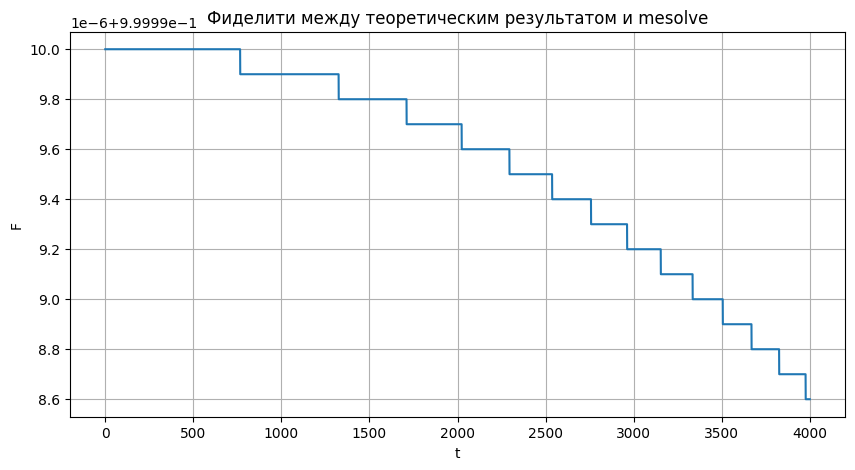

In [24]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fid_teor_vs_mesolve)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделити между теоретическим результатом и mesolve")
ax.grid()

Максимальная абсолютная ошибка в элементе вектора состояния

In [25]:
max_residual_teor_vs_mesolve = [
    np.max(
        np.abs(
            np.array(states_under_hzz_teor_span[i]) - np.array(states_under_hzz_span[i])
        )
    )
    for i in range(len(tspan))
]

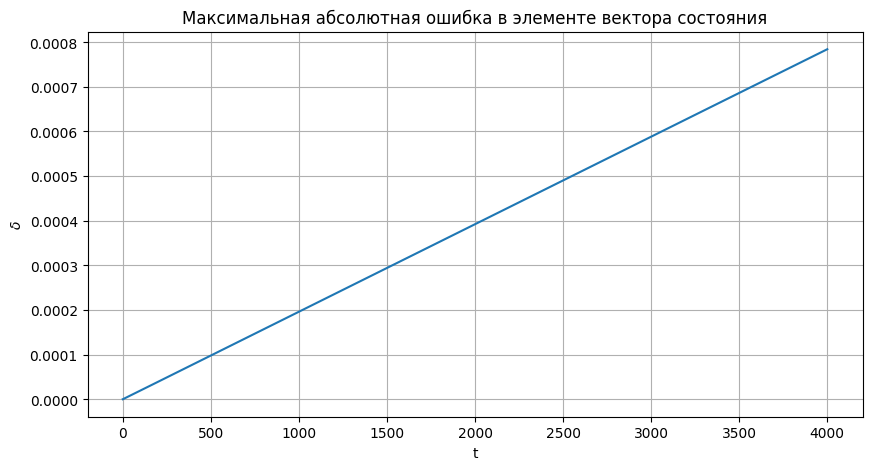

In [26]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, max_residual_teor_vs_mesolve)
ax.set_xlabel("t")
ax.set_ylabel("$\delta$")
ax.set_title("Максимальная абсолютная ошибка в элементе вектора состояния")
ax.grid()

### Энтропия фон Неймана

In [27]:
entropy_1_under_hzz_span = [
    qutip.entropy_vn(qutip.ptrace(s, [2, 3])) for s in states_under_hzz_span
]
entropy_1_under_hzz_teor_span = [
    qutip.entropy_vn(qutip.ptrace(s, [2, 3])) for s in states_under_hzz_teor_span
]

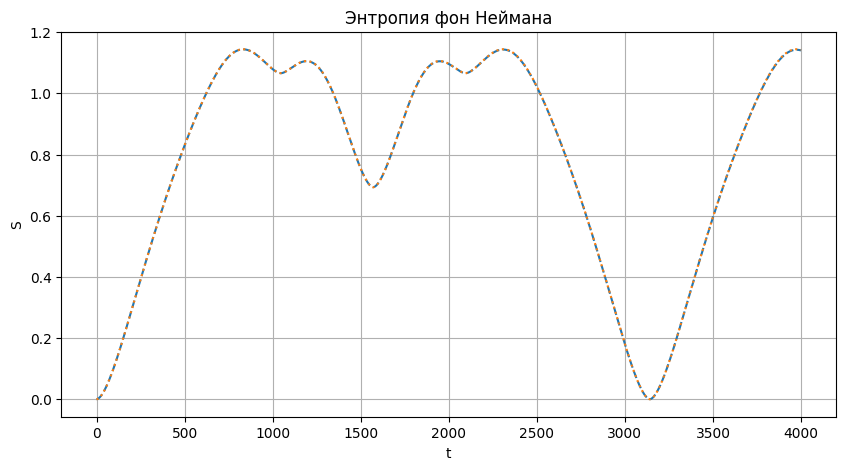

In [28]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, entropy_1_under_hzz_span, "--", label="mesolve")
ax.plot(tspan, entropy_1_under_hzz_teor_span, ":", label="theor")
ax.set_ylabel("S")
ax.set_xlabel("t")
ax.set_title("Энтропия фон Неймана")
ax.grid()

In [29]:
1 / math.sqrt(2 * model.n_bosons) / model.Omega

816.4965809277261

### Сравнение гамильтониана $H^\mathrm{tot}_\mathrm{eff}$ c zz частью

In [30]:
states_under_h_eff_tot_span = qutip.mesolve(
    h_eff_tot, init_state, tspan, [], [], progress_bar=True
).states

10.0%. Run time:   0.11s. Est. time left: 00:00:00:00
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.0%. Run time:   0.31s. Est. time left: 00:00:00:00
40.0%. Run time:   0.41s. Est. time left: 00:00:00:00
50.0%. Run time:   0.51s. Est. time left: 00:00:00:00
60.0%. Run time:   0.61s. Est. time left: 00:00:00:00
70.0%. Run time:   0.71s. Est. time left: 00:00:00:00
80.0%. Run time:   0.80s. Est. time left: 00:00:00:00
90.0%. Run time:   0.90s. Est. time left: 00:00:00:00
Total run time:   1.00s


Фиделити между состояния под эволюцией гамильтониана с земановской частью и без 

In [31]:
fid_zz_vs_tot_eff = [
    np.round(qutip.metrics.fidelity(s1, s2), 7)
    for s1, s2 in zip(states_under_hzz_teor_span, states_under_h_eff_tot_span)
]

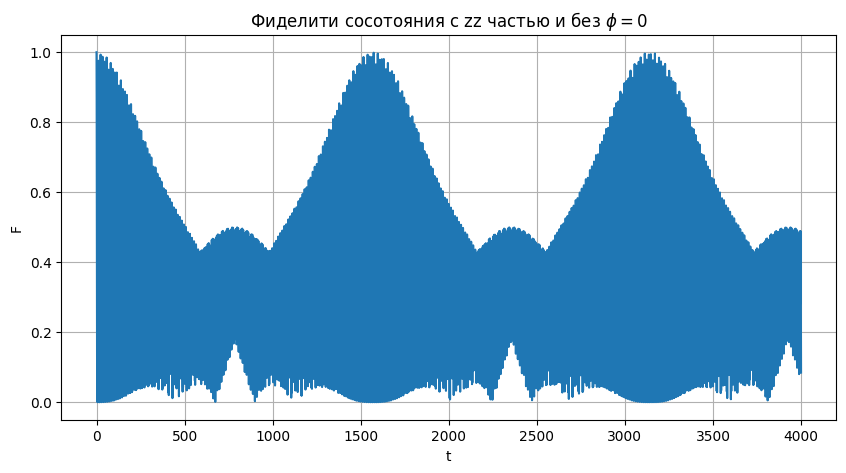

In [32]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fid_zz_vs_tot_eff)
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title(r"Фиделити сосотояния с zz частью и без $\phi = 0$")
ax.grid()

## Спонтанная эмиссия на примере одного кубита

In [33]:
emodel = replace(model, excitation_level=True)

In [34]:
h1 = (
    model.delta * bec.e(emodel).dag() * bec.e(emodel)
    + model.g
    * (bec.a(emodel).dag() * bec.e(emodel) + bec.e(emodel).dag() * bec.a(emodel))
    + model.g
    * (bec.b(emodel).dag() * bec.e(emodel) + bec.e(emodel).dag() * bec.b(emodel))
)

In [35]:
Gamma_s = 0.1
c_ops = [
    Gamma_s * bec.a(emodel).dag() * bec.e(emodel),
    Gamma_s * bec.b(emodel).dag() * bec.e(emodel),
]

In [36]:
init_state = bec.coherent_state_constructor(emodel, 1, 0) * bec.vacuum_state(
    emodel, n=1
)

In [37]:
e_ops = [bec.sz(emodel)]

In [38]:
options = qutip.Options(nsteps=1e8)

In [39]:
t_list = tspan
r = qutip.mesolve(
    h1,
    init_state,
    t_list,
    # e_ops=e_ops,
    c_ops=c_ops,
    options=options,
    progress_bar=True,
)

10.0%. Run time:   9.71s. Est. time left: 00:00:01:27
20.0%. Run time:  19.56s. Est. time left: 00:00:01:18
30.0%. Run time:  29.40s. Est. time left: 00:00:01:08
40.0%. Run time:  39.29s. Est. time left: 00:00:00:58
50.0%. Run time:  49.21s. Est. time left: 00:00:00:49
60.0%. Run time:  59.09s. Est. time left: 00:00:00:39
70.0%. Run time:  69.02s. Est. time left: 00:00:00:29
80.0%. Run time:  79.07s. Est. time left: 00:00:00:19
90.0%. Run time:  88.97s. Est. time left: 00:00:00:09
Total run time:  98.80s


Фиделити начального состояния и эволюционного

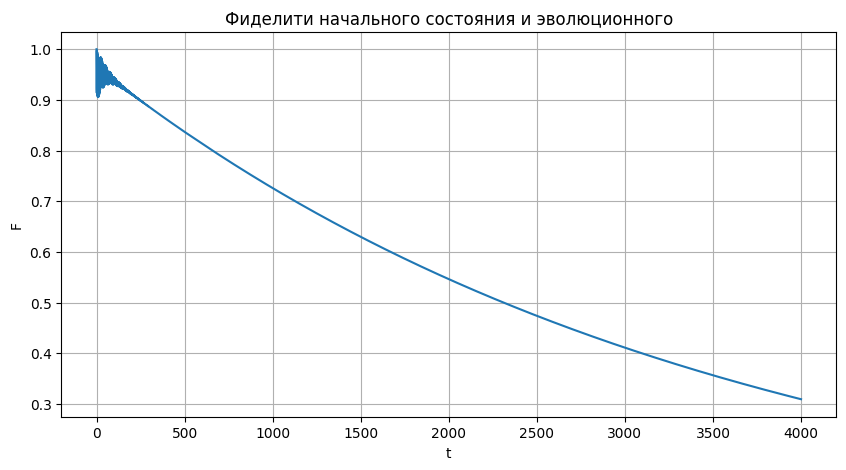

In [40]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t_list, [qutip.metrics.fidelity(init_state, s) for s in r.states])
ax.set_ylabel("F")
ax.set_xlabel("t")
ax.set_title("Фиделити начального состояния и эволюционного")
ax.grid()

Среднее значение оператора $S_z$

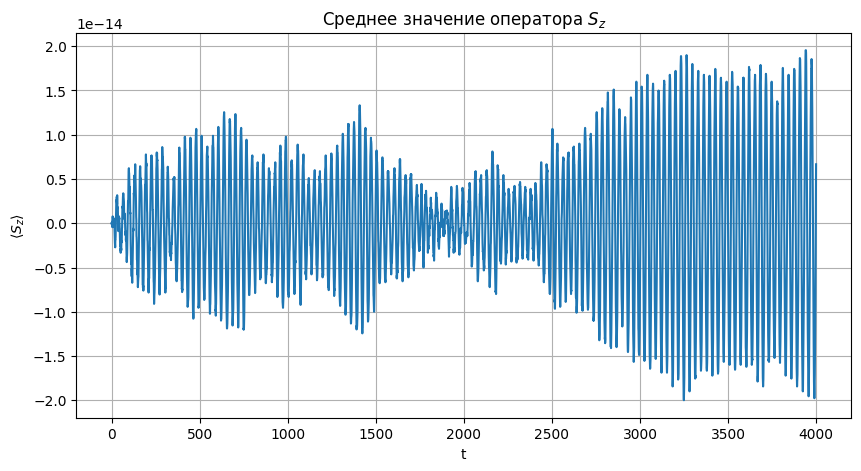

In [41]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(t_list, [qutip.expect(e_ops[0], s) for s in r.states])
ax.set_ylabel(r"$\langle S_z \rangle$")
ax.set_xlabel("t")
ax.set_title("Среднее значение оператора $S_z$")
ax.grid()